# CyRK - SciPy Comparison

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from numba import njit
plt.style.use('dark_background')

### Create a differential equation to test

In [2]:
rtol = 1.0e-7
atol = 1.0e-8

use_pendulum = False

if use_pendulum:
    from CyRK.cy.cysolvertest import CySolverPendulum as CySolverTester
    time_span = (0., 10.)
    args = (1., 1., 9.81)
    initial_conds = np.asarray((0.01, 0.), dtype=np.float64, order='C')
    
    @njit
    def diffeq(t, y, dy, l, m, g):

        # External torque
        torque = 0.1 * np.sin(t)

        y0 = y[0]  # Angular deflection [rad]
        y1 = y[1]  # Angular velocity [rad s-1]
        dy[0] = y1
        dy[1] = (-3. * g / (2. * l)) * np.sin(y0) + (3. / (m * l**2)) * torque
    
    @njit
    def diffeq_scipy(t, y, l, m, g):

        # External torque
        torque = 0.1 * np.sin(t)

        y0 = y[0]  # Angular deflection [rad]
        y1 = y[1]  # Angular velocity [rad s-1]
        dy = np.empty_like(y)
        dy[0] = y1
        dy[1] = (-3. * g / (2. * l)) * np.sin(y0) + (3. / (m * l**2)) * torque
        return dy
    
else:
    from CyRK.cy.cysolvertest import CySolverTester as CySolverTester
    
    initial_conds = np.asarray((20., 20.), dtype=np.float64)
    args = tuple()
    time_span = (0., 50.)
    @njit
    def diffeq(t, y, dy):
        dy[0] = (1. - 0.01 * y[1]) * y[0]
        dy[1] = (0.02 * y[0] - 1.) * y[1]


    # Create helper function for scipy to work with this kind of diffeq
    @njit
    def diffeq_scipy(t, y):

        dy = np.zeros_like(y)
        diffeq(t, y, dy)

        return dy


# Create plotting routine
def diff_plot(t, y, fig_name=None):
    
    # Plot
    fig, ax = plt.subplots()
    ax.plot(t, y[0], 'r', label='$y_{0}$')
    ax.plot(t, y[1], 'b', label='$y_{1}$')
    ax.set(xlabel='$t$', ylabel='$y$')
    ax.legend(loc='best')
    
    # Show figure
    plt.show()
    
    # Save figure
    if fig_name is not None:
        fig.savefig(f'{fig_name}.pdf')

### Check results

SciPy Solution


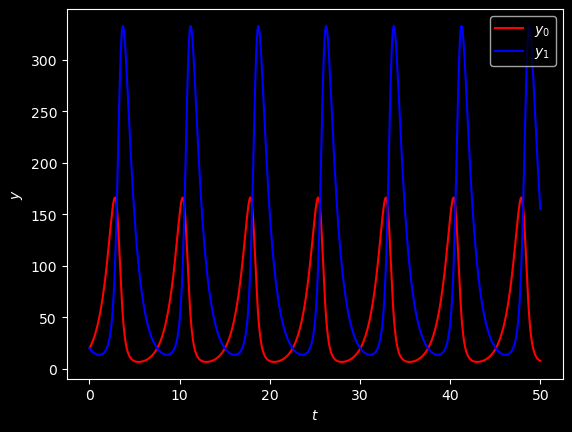

In [3]:
# Scipy
scipy_solution = solve_ivp(diffeq_scipy, time_span, initial_conds, method='RK45', args=args, rtol=rtol, atol=atol)
print('SciPy Solution')
diff_plot(scipy_solution.t, scipy_solution.y, fig_name='SciPy')

CyRK (numba) Solution


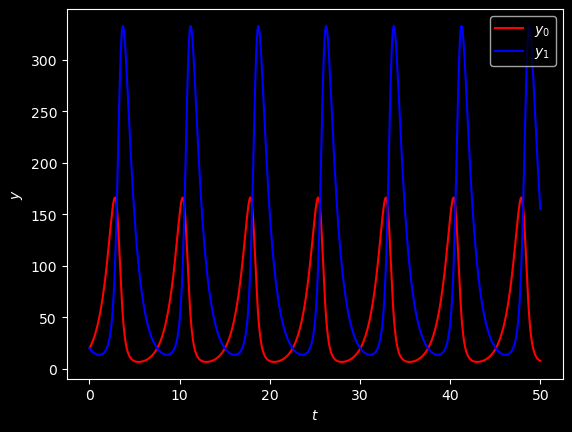

In [4]:
# CyRK - numba implementation
from CyRK import nbrk_ode
time_domain_nb, y_results_nb, success_nb, message_nb = \
    nbrk_ode(diffeq_scipy, time_span, initial_conds, rk_method=1, args=args, rtol=rtol, atol=atol)
print('CyRK (numba) Solution')
diff_plot(time_domain_nb, y_results_nb, fig_name='CyRK_numba')

CyRK (Cython - cyrk_ode) Solution


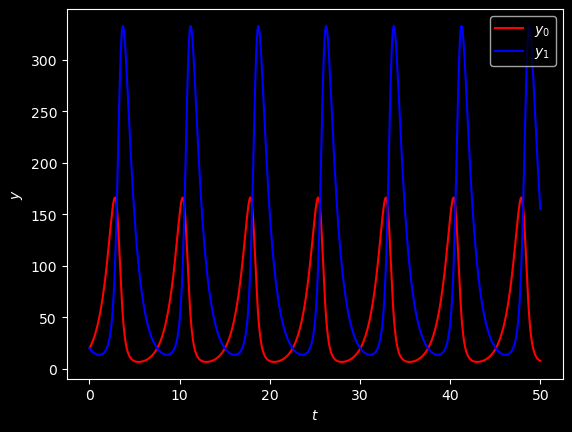

In [5]:
# CyRK -  Cython cyrk_ode
from CyRK import cyrk_ode
time_domain, y_results, success, message = cyrk_ode(diffeq, time_span, initial_conds, args=args, 
                                                    rk_method=1, rtol=rtol, atol=atol)
print('CyRK (Cython - cyrk_ode) Solution')
diff_plot(time_domain, y_results, fig_name='CyRK_cyrk_ode')

CyRK (Cython - CySolver) Solution


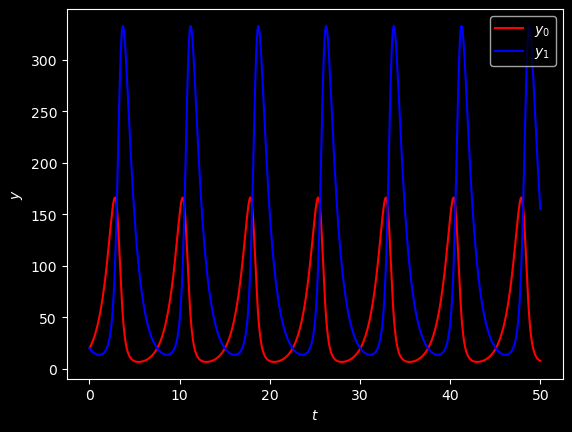

In [6]:
# CyRK - Cython CySolver
CySolverTesterInst = CySolverTester(time_span, initial_conds, rk_method=1, args=args, rtol=rtol, atol=atol, auto_solve=True)
print('CyRK (Cython - CySolver) Solution')
diff_plot(time_domain, y_results, fig_name='CyRK_CySolver')

### Check Performance

In [7]:
import timeit

REPEATS = 4
print('This can take a while...\n')
# Run Results
# rtols = np.logspace(-3, -13, 11)
end_times = np.logspace(-3, 5, 9)

sci_steps = list()
nb_steps = list()
cy_steps = list()
cysolver_steps = list()

sci_times = list()
nb_times = list()
cy_times = list()
cysolver_times = list()

sci_errors = list()
nb_errors = list()
cy_errors = list()
cysolver_errors = list()

for end_time in end_times:
    
    time_s = (0., end_time)
    
    print(f'Working on end_time = {end_time:0.1e}.')
    print(f'\tNumba Pre-Compile')
    _ = nbrk_ode(diffeq_scipy, time_s, initial_conds, rk_method=1, args=args, rtol=rtol, atol=atol)
    
    print('\tWorking on SciPy')
    sci_timer = timeit.Timer(lambda: solve_ivp(diffeq_scipy, time_s, initial_conds, method='RK45', args=args, rtol=rtol, atol=atol))
    scipy_time_list = list()
    for i in range(REPEATS):
        N, T = sci_timer.autorange()
        scipy_time_list.append(T / N * 1000.)
    scipy_time_list = np.asarray(scipy_time_list)
    sci_times.append(np.average(scipy_time_list))
    sci_errors.append(np.std(scipy_time_list))
    _sol = solve_ivp(diffeq_scipy, time_s, initial_conds, method='RK45', args=args, rtol=rtol, atol=atol)
    sci_steps.append(_sol.t.size)
    print('\tFinished SciPy.')
    
    print('\tWorking on numba')
    nb_timer = timeit.Timer(lambda: nbrk_ode(diffeq_scipy, time_s, initial_conds, rk_method=1, args=args, rtol=rtol, atol=atol))
    nb_times_list = list()
    for i in range(REPEATS):
        N, T = nb_timer.autorange()
        nb_times_list.append(T / N * 1000.)
    nb_times_list = np.asarray(nb_times_list)
    nb_times.append(np.average(nb_times_list))
    nb_errors.append(np.std(nb_times_list))
    _out = nbrk_ode(diffeq_scipy, time_s, initial_conds, rk_method=1, args=args, rtol=rtol, atol=atol)
    nb_steps.append(_out[0].size)
    print('\tFinished numba.')
    
    print('\tWorking on cython - cyrk_ode')
    cy_timer = timeit.Timer(lambda: cyrk_ode(diffeq, time_s, initial_conds, rk_method=1, args=args, rtol=rtol, atol=atol))
    cy_times_list = list()
    for i in range(REPEATS):
        N, T = cy_timer.autorange()
        cy_times_list.append(T / N * 1000.)
    cy_times_list = np.asarray(cy_times_list)
    cy_times.append(np.average(cy_times_list))
    cy_errors.append(np.std(cy_times_list))
    _out = cyrk_ode(diffeq, time_s, initial_conds, rk_method=1, args=args, rtol=rtol, atol=atol)
    cy_steps.append(_out[0].size)
    print('\tFinished cython - cyrk_ode.')
    
    print('\tWorking on cython - CySolver')
    cysolver_timer = timeit.Timer(lambda: CySolverTester(time_s, initial_conds, rk_method=1, args=args, rtol=rtol, atol=atol, auto_solve=True))
    cysolver_times_list = list()
    for i in range(REPEATS):
        N, T = cysolver_timer.autorange()
        cysolver_times_list.append(T / N * 1000.)
    cysolver_times_list = np.asarray(cysolver_times_list)
    cysolver_times.append(np.average(cysolver_times_list))
    cysolver_errors.append(np.std(cysolver_times_list))
    CyInst = CySolverTester(time_s, initial_conds, rk_method=1, args=args, rtol=rtol, atol=atol, auto_solve=True)
    cysolver_steps.append(CyInst.t.size)
    print('\tFinished cython - CySolver.')
    
print('Done!')

This can take a while...

Working on end_time = 1.0e-03.
	Numba Pre-Compile
	Working on SciPy
	Finished SciPy.
	Working on numba
	Finished numba.
	Working on cython - cyrk_ode
	Finished cython - cyrk_ode.
	Working on cython - CySolver
	Finished cython - CySolver.
Working on end_time = 1.0e-02.
	Numba Pre-Compile
	Working on SciPy
	Finished SciPy.
	Working on numba
	Finished numba.
	Working on cython - cyrk_ode
	Finished cython - cyrk_ode.
	Working on cython - CySolver
	Finished cython - CySolver.
Working on end_time = 1.0e-01.
	Numba Pre-Compile
	Working on SciPy
	Finished SciPy.
	Working on numba
	Finished numba.
	Working on cython - cyrk_ode
	Finished cython - cyrk_ode.
	Working on cython - CySolver
	Finished cython - CySolver.
Working on end_time = 1.0e+00.
	Numba Pre-Compile
	Working on SciPy
	Finished SciPy.
	Working on numba
	Finished numba.
	Working on cython - cyrk_ode
	Finished cython - cyrk_ode.
	Working on cython - CySolver
	Finished cython - CySolver.
Working on end_time = 

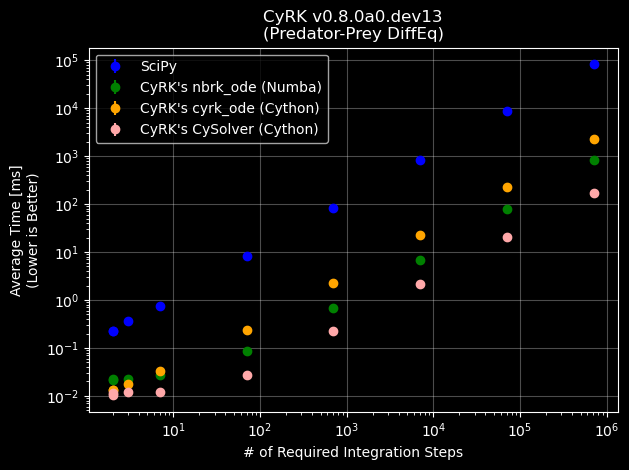

In [8]:
from CyRK import version

version_filesafe = version.replace('.', '-')

# Plot Results
sci_steps = np.asarray(sci_steps)
nb_steps = np.asarray(nb_steps)
cy_steps = np.asarray(cy_steps)
cysolver_steps = np.asarray(cysolver_steps)

sci_times = np.asarray(sci_times)
nb_times = np.asarray(nb_times)
cy_times = np.asarray(cy_times)
cysolver_times = np.asarray(cysolver_times)

sci_errors = np.asarray(sci_errors)
nb_errors = np.asarray(nb_errors)
cy_errors = np.asarray(cy_errors)
cysolver_errors = np.asarray(cysolver_errors)

fig, ax = plt.subplots()

plot_vs_steps = True
if plot_vs_steps:
    ax.errorbar(sci_steps, sci_times, yerr=sci_errors, c='blue', label='SciPy', fmt='o')
    ax.errorbar(nb_steps, nb_times, yerr=nb_errors, c='green', label="CyRK's nbrk_ode (Numba)", fmt='o')
    ax.errorbar(cy_steps, cy_times, yerr=cy_errors, c='orange', label="CyRK's cyrk_ode (Cython)", fmt='o')
    ax.errorbar(cysolver_steps, cysolver_times, yerr=cysolver_errors, c='#ffa8a9', label="CyRK's CySolver (Cython)", fmt='o')
else:
    ax.errorbar(end_times, sci_times, yerr=sci_errors, c='blue', label='SciPy', fmt='o')
    ax.errorbar(end_times, nb_times, yerr=nb_errors, c='green', label="CyRK's nbrk_ode (Numba)", fmt='o')
    ax.errorbar(end_times, cy_times, yerr=cy_errors, c='orange', label="CyRK's cyrk_ode (Cython)", fmt='o')
    ax.errorbar(end_times, cysolver_times, yerr=cysolver_errors, c='#ffa8a9', label="CyRK's CySolver (Cython)", fmt='o')

if use_pendulum:
    title_name = f'CyRK v{version}\n(Pendulum DiffEq)'
else:
    title_name = f'CyRK v{version}\n(Predator-Prey DiffEq)'

if plot_vs_steps:
    ax.set(ylabel='Average Time [ms]\n(Lower is Better)', xlabel='# of Required Integration Steps', xscale='log', yscale='log')
else:
    ax.set(ylabel='Average Time [ms]\n(Lower is Better)', xlabel='Integration Domain Size', xscale='log', yscale='log')
    ax.set_xticks((1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5))
ax.grid(alpha=0.3)
# ax.set_xlim(ax.get_xlim()[::-1])

ax.legend(loc='best')
ax.set(title=title_name)
fig.tight_layout()
if use_pendulum:
    fig.savefig(f'CyRK_SciPy_Compare_pendulum_v{version_filesafe}.png')
else:
    fig.savefig(f'CyRK_SciPy_Compare_predprey_v{version_filesafe}.png')
plt.show()

In [9]:
# Print Differences
print('How much faster X is vs. Y')
for end_time, sci, nb, cy, cys in zip(end_times, sci_times, nb_times, cy_times, cysolver_times):
    
    print(f'End Time: {end_time:0.1e}')
    print(f'\t nbrk_ode = {sci / nb:5.1f}x solve_ivp', end='')
    print(f'\t cyrk_ode = {sci / cy:5.1f}x solve_ivp', end='\n')
    print(f'\t CySolver = {sci / cys:5.1f}x solve_ivp', end='')
    print(f'\t nbrk_ode = {cy / nb:5.1f}x cyrk_ode', end='\n')
    print(f'\t CySolver = { nb / cys:5.1f}x nbrk_ode', end='')
    print(f'\t CySolver = { cy / cys:5.1f}x cyrk_ode', end='\n')

How much faster X is vs. Y
End Time: 1.0e-03
	 nbrk_ode =  10.8x solve_ivp	 cyrk_ode =  17.4x solve_ivp
	 CySolver =  21.5x solve_ivp	 nbrk_ode =   0.6x cyrk_ode
	 CySolver =   2.0x nbrk_ode	 CySolver =   1.2x cyrk_ode
End Time: 1.0e-02
	 nbrk_ode =  10.2x solve_ivp	 cyrk_ode =  17.2x solve_ivp
	 CySolver =  20.1x solve_ivp	 nbrk_ode =   0.6x cyrk_ode
	 CySolver =   2.0x nbrk_ode	 CySolver =   1.2x cyrk_ode
End Time: 1.0e-01
	 nbrk_ode =  16.6x solve_ivp	 cyrk_ode =  21.0x solve_ivp
	 CySolver =  30.6x solve_ivp	 nbrk_ode =   0.8x cyrk_ode
	 CySolver =   1.8x nbrk_ode	 CySolver =   1.5x cyrk_ode
End Time: 1.0e+00
	 nbrk_ode =  28.7x solve_ivp	 cyrk_ode =  23.2x solve_ivp
	 CySolver =  63.4x solve_ivp	 nbrk_ode =   1.2x cyrk_ode
	 CySolver =   2.2x nbrk_ode	 CySolver =   2.7x cyrk_ode
End Time: 1.0e+01
	 nbrk_ode =  95.6x solve_ivp	 cyrk_ode =  35.4x solve_ivp
	 CySolver = 297.2x solve_ivp	 nbrk_ode =   2.7x cyrk_ode
	 CySolver =   3.1x nbrk_ode	 CySolver =   8.4x cyrk_ode
End Time: 1.0